# Run meta-analyses on 21 pain studies
In this notebook, we will run a series of image- and coordinate-based meta-analyses on a dataset containing statistical maps from 21 studies of pain.

Collection of NIDM-Results packs downloaded from Neurovault collection [1425](https://www.neurovault.org/collections/1425/), uploaded by Dr. Camille Maumet.

In [1]:
%matplotlib inline
import os
import urllib.request

import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.masking import apply_mask, unmask
from nilearn.plotting import plot_stat_map

import nimare
from nimare.meta.esma import fishers
from nimare.meta.ibma import (Fishers, Stouffers, WeightedStouffers,
                              RFX_GLM, FFX_GLM, ffx_glm)

/Users/tsalo/.local/lib/python3.6/site-packages/scikit_learn-0.21.2-py3.6-macosx-10.7-x86_64.egg/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
url = "https://raw.githubusercontent.com/tsalo/NiMARE/coco2019/download_test_data.py"
u = urllib.request.urlopen(url)
data = u.read()
u.close()

# write python to file
with open("download_test_data.py", "wb") as f:
    f.write(data)

# download the requisite data
from download_test_data import download_dataset
dset_dir = download_dataset()
os.remove("download_test_data.py")

In [3]:
dset_file = os.path.join(os.path.dirname(nimare.__file__),
                         'tests', 'data', 'nidm_pain_dset.json')
dset = nimare.dataset.Dataset(dset_file)
dset.update_path(dset_dir)

mask_img = dset.masker.mask_img

logp_thresh = -np.log(.05)

# Image-based meta-analyses
IBMA algorithms can be performed using functions operating on arrays or Estimators operating on datasets. If you use a function, you will need to wrangle and mask your data ahead of time. If you use an Estimator, it will internally find all matching data within the dataset and analyze that subset specifically.

For the first meta-analysis, we will show both the function-based and Estimator-based approaches. After that, we will switch to just using the Estimator-based approach for subsequent meta-analyses.

## Fisher's

11 studies found.
CPU times: user 2.32 s, sys: 364 ms, total: 2.68 s
Wall time: 3.32 s


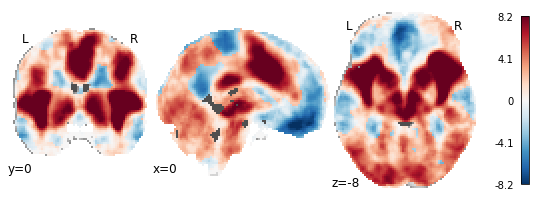

In [4]:
%%time
# Get images for analysis
files = dset.get_images(imtype='z')
files = [f for f in files if f]
z_imgs = [nib.load(f) for f in files]
z_data = apply_mask(z_imgs, mask_img)
print('{0} studies found.'.format(z_data.shape[0]))

result = fishers(z_data, mask_img)
fishers_result = unmask(result['z'], mask_img)
plot_stat_map(fishers_result, cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

INFO:nimare.dataset:Retaining 11/21 studies


CPU times: user 2.07 s, sys: 321 ms, total: 2.39 s
Wall time: 2.57 s


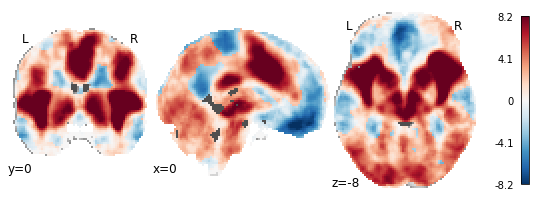

In [5]:
%%time
# Here is the object-oriented approach
meta = Fishers()
meta.fit(dset)
plot_stat_map(meta.results.get_map('z'), cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

## Stouffer's

### Fixed-effects inference

INFO:nimare.dataset:Retaining 11/21 studies


CPU times: user 1.88 s, sys: 252 ms, total: 2.13 s
Wall time: 2.12 s


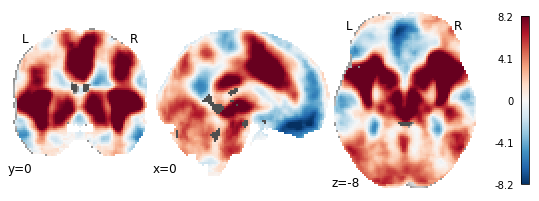

In [6]:
%%time
meta = Stouffers(inference='ffx', null='theoretical', n_iters=None)
meta.fit(dset)
plot_stat_map(meta.results.get_map('z'), cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

### Random-effects inference with theoretical null distribution

INFO:nimare.dataset:Retaining 11/21 studies
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


CPU times: user 2.07 s, sys: 277 ms, total: 2.34 s
Wall time: 2.56 s


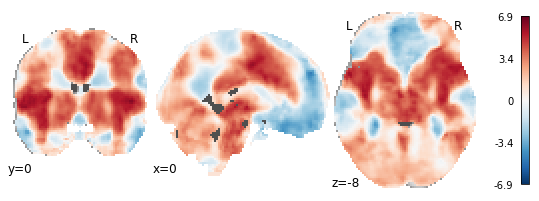

In [7]:
%%time
meta = Stouffers(inference='rfx', null='theoretical', n_iters=None)
meta.fit(dset)
plot_stat_map(meta.results.get_map('z'), cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

### Random-effects inference with empirical null distribution

INFO:nimare.dataset:Retaining 11/21 studies
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


CPU times: user 1min 28s, sys: 9.61 s, total: 1min 37s
Wall time: 1min 45s


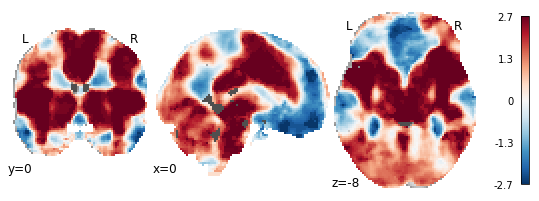

In [8]:
%%time
meta = Stouffers(inference='rfx', null='empirical', n_iters=1000)
meta.fit(dset)
plot_stat_map(meta.results.get_map('z'), cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

## Weighted Stouffer's

INFO:nimare.dataset:Retaining 11/21 studies


CPU times: user 1.99 s, sys: 262 ms, total: 2.26 s
Wall time: 2.45 s


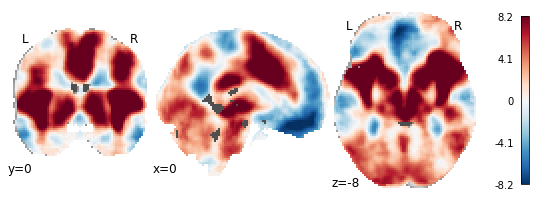

In [9]:
%%time
meta = WeightedStouffers()
meta.fit(dset)
plot_stat_map(meta.results.get_map('z'), cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

## FFX GLM

191120-09:27:19,226 nipype.interface INFO:
	 stdout 2019-11-20T09:27:19.226047:Log directory is: stats


INFO:nipype.interface:stdout 2019-11-20T09:27:19.226047:Log directory is: stats


191120-09:27:19,230 nipype.interface INFO:
	 stdout 2019-11-20T09:27:19.230378:Setting up:


INFO:nipype.interface:stdout 2019-11-20T09:27:19.230378:Setting up:


191120-09:27:20,78 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.078715:ntptsing=21.000000 


INFO:nipype.interface:stdout 2019-11-20T09:27:20.078715:ntptsing=21.000000 


191120-09:27:20,82 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.078715:


INFO:nipype.interface:stdout 2019-11-20T09:27:20.078715:


191120-09:27:20,91 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.078715:evs_group=1.000000 


INFO:nipype.interface:stdout 2019-11-20T09:27:20.078715:evs_group=1.000000 


191120-09:27:20,98 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.078715:


INFO:nipype.interface:stdout 2019-11-20T09:27:20.078715:


191120-09:27:20,108 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.108292:No f contrasts


INFO:nipype.interface:stdout 2019-11-20T09:27:20.108292:No f contrasts


191120-09:27:20,263 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.263371:


INFO:nipype.interface:stdout 2019-11-20T09:27:20.263371:


191120-09:27:20,265 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.263371:WARNING: The passed in varcope file, /Users/tsalo/Documents/tsalo/NiMARE/examples/ffx_glm/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from the analysis.


INFO:nipype.interface:stdout 2019-11-20T09:27:20.263371:WARNING: The passed in varcope file, /Users/tsalo/Documents/tsalo/NiMARE/examples/ffx_glm/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from the analysis.


191120-09:27:20,278 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.278270:nevs=1


INFO:nipype.interface:stdout 2019-11-20T09:27:20.278270:nevs=1


191120-09:27:20,281 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.278270:ntpts=21


INFO:nipype.interface:stdout 2019-11-20T09:27:20.278270:ntpts=21


191120-09:27:20,284 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.278270:ngs=1


INFO:nipype.interface:stdout 2019-11-20T09:27:20.278270:ngs=1


191120-09:27:20,287 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.278270:nvoxels=189370


INFO:nipype.interface:stdout 2019-11-20T09:27:20.278270:nvoxels=189370


191120-09:27:20,337 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.337125:Running:


INFO:nipype.interface:stdout 2019-11-20T09:27:20.337125:Running:


191120-09:27:20,338 nipype.interface INFO:
	 stdout 2019-11-20T09:27:20.337125:nmaskvoxels=189370


INFO:nipype.interface:stdout 2019-11-20T09:27:20.337125:nmaskvoxels=189370


191120-09:27:22,691 nipype.interface INFO:
	 stdout 2019-11-20T09:27:22.691351: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


INFO:nipype.interface:stdout 2019-11-20T09:27:22.691351: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


191120-09:27:22,693 nipype.interface INFO:
	 stdout 2019-11-20T09:27:22.691351:Saving results


INFO:nipype.interface:stdout 2019-11-20T09:27:22.691351:Saving results


191120-09:27:25,370 nipype.interface INFO:
	 stdout 2019-11-20T09:27:25.370674:


INFO:nipype.interface:stdout 2019-11-20T09:27:25.370674:


191120-09:27:25,372 nipype.interface INFO:
	 stdout 2019-11-20T09:27:25.370674:Log directory was: stats


INFO:nipype.interface:stdout 2019-11-20T09:27:25.370674:Log directory was: stats


191120-09:27:26,713 nipype.interface INFO:
	 stdout 2019-11-20T09:27:26.713417:DLH 0.0310792


INFO:nipype.interface:stdout 2019-11-20T09:27:26.713417:DLH 0.0310792


191120-09:27:26,717 nipype.interface INFO:
	 stdout 2019-11-20T09:27:26.713417:VOLUME 189370


INFO:nipype.interface:stdout 2019-11-20T09:27:26.713417:VOLUME 189370


191120-09:27:26,725 nipype.interface INFO:
	 stdout 2019-11-20T09:27:26.713417:RESELS 152.874


INFO:nipype.interface:stdout 2019-11-20T09:27:26.713417:RESELS 152.874


191120-09:27:26,734 nipype.interface INFO:
	 stdout 2019-11-20T09:27:26.713417:FWHMvoxel 5.04435 5.04435 5.04435


INFO:nipype.interface:stdout 2019-11-20T09:27:26.713417:FWHMvoxel 5.04435 5.04435 5.04435


191120-09:27:26,737 nipype.interface INFO:
	 stdout 2019-11-20T09:27:26.713417:FWHMmm 10.0887 10.6591 11.3728


INFO:nipype.interface:stdout 2019-11-20T09:27:26.713417:FWHMmm 10.0887 10.6591 11.3728


191120-09:27:27,9 nipype.interface INFO:
	 stdout 2019-11-20T09:27:27.008978:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


INFO:nipype.interface:stdout 2019-11-20T09:27:27.008978:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


191120-09:27:27,12 nipype.interface INFO:
	 stdout 2019-11-20T09:27:27.008978:2	66340	0	85.5	11.2	54	2	2	7.73	-8	12.7	1.45	58	-26	22	0.3


INFO:nipype.interface:stdout 2019-11-20T09:27:27.008978:2	66340	0	85.5	11.2	54	2	2	7.73	-8	12.7	1.45	58	-26	22	0.3


191120-09:27:27,22 nipype.interface INFO:
	 stdout 2019-11-20T09:27:27.008978:1	1145	4.7e-05	4.33	5.45	50	-36	-22	53	-40.4	-16.3	0.466	60	-56	-14	0.197


INFO:nipype.interface:stdout 2019-11-20T09:27:27.008978:1	1145	4.7e-05	4.33	5.45	50	-36	-22	53	-40.4	-16.3	0.466	60	-56	-14	0.197


191120-09:27:27,888 nipype.interface INFO:
	 stdout 2019-11-20T09:27:27.887708:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


INFO:nipype.interface:stdout 2019-11-20T09:27:27.887708:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


191120-09:27:27,892 nipype.interface INFO:
	 stdout 2019-11-20T09:27:27.887708:1	524	0.0107	1.97	4.68	-2	-54	10	0.442	-55.1	11.5	0.517	-2	-54	10	0.257


INFO:nipype.interface:stdout 2019-11-20T09:27:27.887708:1	524	0.0107	1.97	4.68	-2	-54	10	0.442	-55.1	11.5	0.517	-2	-54	10	0.257
INFO:nimare.meta.ibma:Cleaning up...


CPU times: user 8.03 s, sys: 1.34 s, total: 9.36 s
Wall time: 17.4 s


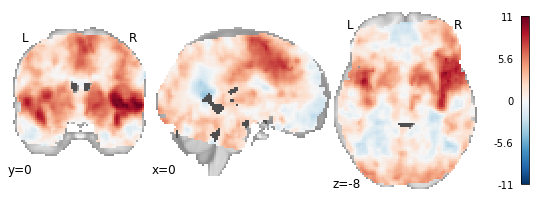

In [10]:
%%time
meta = FFX_GLM()
meta.fit(dset)
plot_stat_map(meta.results.get_map('z'), cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

## RFX GLM

### Theoretical null distribution

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


CPU times: user 2.42 s, sys: 350 ms, total: 2.77 s
Wall time: 2.71 s


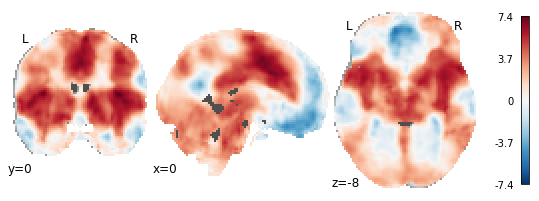

In [11]:
%%time
meta = RFX_GLM(null='theoretical', n_iters=None)
meta.fit(dset)
plot_stat_map(meta.results.get_map('z'), cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

### Empirical null distribution

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


CPU times: user 1min 54s, sys: 14.8 s, total: 2min 8s
Wall time: 2min 18s


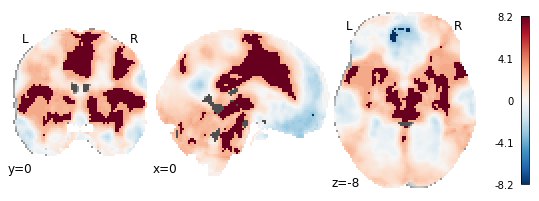

In [12]:
%%time
meta = RFX_GLM(null='empirical', n_iters=1000)
meta.fit(dset)
plot_stat_map(meta.results.get_map('z'), cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

# Coordinate-based meta-analyses

## MKDA

### Density analysis

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/cbma/mkda.py:178: RuntimeWarning: divide by zero encountered in log
  vfwe_map[i_vox] = -np.log(null_to_p(val, perm_max_values, 'upper'))


CPU times: user 8.28 s, sys: 415 ms, total: 8.7 s
Wall time: 10.6 s


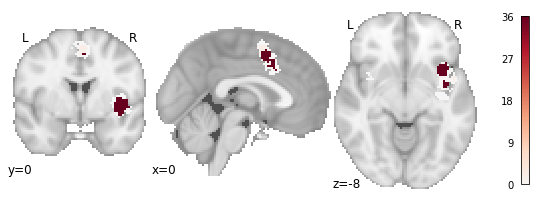

In [13]:
%%time
mkda = nimare.meta.MKDADensity(kernel__r=10)
mkda.fit(dset)
corr = nimare.correct.FWECorrector(method='permutation', n_iters=10, n_cores=1)
cres = corr.transform(mkda.results)
plot_stat_map(cres.get_map('logp_level-voxel_corr-FWE_method-permutation'),
              cut_coords=[0, 0, -8], draw_cross=False, cmap='RdBu_r')

### Chi2 with FDR correction

/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/cbma/mkda.py:277: RuntimeWarning: invalid value encountered in true_divide
  pFgA = pAgF * pF / pA
/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/cbma/mkda.py:281: RuntimeWarning: invalid value encountered in true_divide
  pFgA_prior = pAgF * self.prior / pAgF_prior


CPU times: user 3.21 s, sys: 308 ms, total: 3.52 s
Wall time: 5.54 s


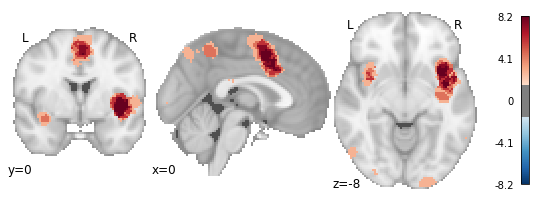

In [14]:
%%time
mkda = nimare.meta.MKDAChi2(kernel__r=10)
dset1 = dset.slice(dset.ids)
dset2 = dset.slice(dset.ids)
mkda.fit(dset1, dset2)
corr = nimare.correct.FDRCorrector(method='fdr_bh', alpha=0.001)
cres = corr.transform(mkda.results)
plot_stat_map(cres.get_map('consistency_z_FDR_corr-FDR_method-fdr_bh'),
              threshold=1.65, cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

### Chi2 with FWE correction

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


CPU times: user 11.6 s, sys: 880 ms, total: 12.5 s
Wall time: 15.8 s


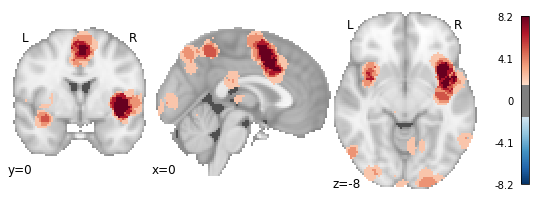

In [15]:
%%time
corr = nimare.correct.FWECorrector(method='permutation', n_iters=10, n_cores=1)
cres = corr.transform(mkda.results)
plot_stat_map(cres.get_map('consistency_z'), threshold=1.65,
              cut_coords=[0, 0, -8], draw_cross=False, cmap='RdBu_r')

## KDA

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


CPU times: user 6.66 s, sys: 309 ms, total: 6.97 s
Wall time: 7.4 s


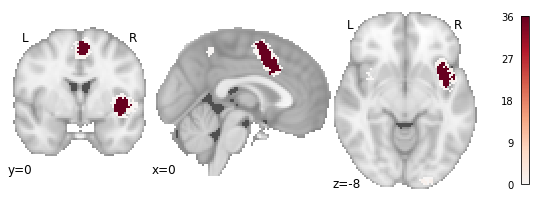

In [16]:
%%time
kda = nimare.meta.KDA(kernel__r=10)
kda.fit(dset)
corr = nimare.correct.FWECorrector(method='permutation', n_iters=10, n_cores=1)
cres = corr.transform(kda.results)
plot_stat_map(cres.get_map('logp_level-voxel_corr-FWE_method-permutation'),
              cut_coords=[0, 0, -8], draw_cross=False, cmap='RdBu_r')

## ALE

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


CPU times: user 9.78 s, sys: 1.28 s, total: 11.1 s
Wall time: 13.9 s


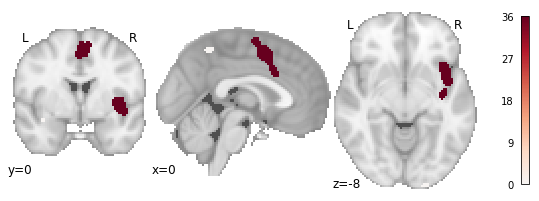

In [17]:
%%time
ale = nimare.meta.ALE()
ale.fit(dset)
corr = nimare.correct.FWECorrector(method='permutation', n_iters=10, n_cores=1)
cres = corr.transform(ale.results)
plot_stat_map(cres.get_map('logp_level-cluster_corr-FWE_method-permutation'),
              cut_coords=[0, 0, -8], draw_cross=False, cmap='RdBu_r')

## SCALE

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


CPU times: user 37.4 s, sys: 6.27 s, total: 43.7 s
Wall time: 45.1 s


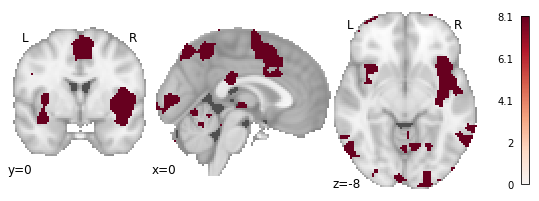

In [18]:
%%time
ijk = np.vstack(np.where(mask_img.get_fdata())).T
scale = nimare.meta.SCALE(ijk=ijk, n_iters=10, n_cores=1)
scale.fit(dset)
plot_stat_map(scale.results.get_map('z_vthresh'), cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')